In [2]:
import os
import json
import sympy
import requests

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from mira.metamodel import *
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json

In [3]:
%load_ext autoreload
%autoreload 1

In [4]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"

model1 = os.path.join(MODEL_PATH, "SEIRD_base_model01_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_base_model01_petrinet.json")
model3 = os.path.join(MODEL_PATH, "LV_sheep_foxes.json")

In [5]:
start_time = 0.0
end_time = 5.0
logging_step_size = 1
num_samples = 20
n = 10

In [6]:
result1 = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)
display(result1['data'].head())
result1['data'][['timepoint_id', 'sample_id', 'S_state', 'I_state']].to_csv('sir.csv', index= False) # 


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_death_param,persistent_gamma_param,persistent_I0_param,S_state,I_state,E_state,R_state,D_state,infected_observable_state,dead_observable_state
0,0,0,0.0,0.271719,0.009915,0.370587,1.448924,19339998.0,1.448924,40.000000,0.000000,0.000000,1.448924,0.000000
1,1,0,1.0,0.271719,0.009915,0.370587,1.448924,19339998.0,8.455902,32.466671,1.953322,0.019560,8.455902,0.019560
2,2,0,2.0,0.271719,0.009915,0.370587,1.448924,19339998.0,12.067674,27.819883,5.794510,0.058026,12.067674,0.058026
3,3,0,3.0,0.271719,0.009915,0.370587,1.448924,19339974.0,13.787673,24.810329,10.580090,0.105948,13.787673,0.105948
4,4,0,4.0,0.271719,0.009915,0.370587,1.448924,19339988.0,14.458996,22.736372,15.785446,0.158073,14.458996,0.158073


### Plot histogram per state combination


In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
from pyciemss.visuals import plots, vega
bin_outliers = False
log = False

# loading SIR data
sir_dataset = pd.read_csv("sir.csv")


def process_dataset(sir_dataset, bin_outliers, log):
    """
    This function bins the columns in the dataset that includes "_state" and plots histograms for each column.
    
    Inputs:
    sir_dataset (pd.DataFrame): The dataset with states, timepoint_id and sample_id
    bin_outliers (bool): A boolean value indicating whether to bin outliers separately in their own bin.
    log (bool): A boolean value indicating whether to use a log scale for the bins.
    
    Outputs:
    sir_dataset (pd.DataFrame): The processed dataset with added bin columns.
    bin_dict (dict): A dictionary storing the min and max values of each bin per column.
    """
    # Determine the number of bins using Sturges' rule and the nu
    num_bins =  math.ceil(math.log2(sir_dataset.shape[0]))

    sir_dataset_state = sir_dataset.loc[:, sir_dataset.columns.str.contains('_state')]

    # dictionary to store the min and max values of each bin per column
    bin_dict = {}

    sir_dataset_output = sir_dataset.copy()

    for col in sir_dataset_state.columns:
        max_val = sir_dataset_output[col].max()
        min_val = sir_dataset_output[col].min()

        # Calculate the 5th and 95th percentiles
        p5, p95 = sir_dataset_output[col].quantile([0.05, 0.95])

        # get histogram in the logspace
        if log:
            if bin_outliers:
                # put all outliers in their own bin at the end (trying to avoid the massive histogram bin for the S_state)
                p5_log = np.log10(p5)
                p95_log = np.log10(p95)

                bin_edges = np.logspace(np.max([0.0, p5_log]), p95_log, num=num_bins)
                bin_edges = np.concatenate(([min_val], bin_edges, [max_val]))
            else:
                min_log= np.log10(min_val)
                max_log = np.log10(max_val)
                bin_edges = np.logspace(np.max([0.0, min_log]), max_log, num=num_bins)
        else:
            if bin_outliers:
                bin_edges = np.linspace(p5, p95, num=num_bins)
                bin_edges = np.concatenate(([min_val], bin_edges, [max_val]))
            else: 
                bin_edges = np.linspace(min_val, max_val, num=num_bins)

        # saving bins edges in dictionary by state and bin number
        bin_dict[col] = [{i:(bin_edges[i], bin_edges[i+1])} for i in range(len(bin_edges)-1)]
        # add column with the bin number per histogram
        sir_dataset_output[col + '_bin'] = sir_dataset_output[col].apply(lambda x: np.digitize(x, bin_edges))

    # create a new column that combines the bin information for each state
    sir_dataset_output['combined_bin'] = sir_dataset_output.apply(lambda row: '_'.join([f"{col.replace('_state_bin','')}_{int(row[col])}" for col in sir_dataset_output.columns if '_bin' in col]), axis=1)

    # create a mapping from original labels to shorter labels
    unique_bins = sir_dataset_output['combined_bin'].unique()
    label_mapping = {bin: f'bin_{i}' for i, bin in enumerate(unique_bins)}
    sir_dataset_output['short_bin'] = sir_dataset_output['combined_bin'].map(label_mapping)

    # save the mapping to a CSV file
    pd.DataFrame(list(label_mapping.items()), columns=['original_label', 'short_label']).to_csv('label_mapping.csv', index=False)

    return sir_dataset_output, bin_dict




In [8]:

def remove_consecutive_duplicates(lst):
    if not lst:  # if the list is empty, return it
        return lst
    new_lst = [lst[0]]  # add the first item of lst to new_lst
    for item in lst[1:]:  # iterate over the rest of lst
        if item != new_lst[-1]:  # if the current item is not the same as the last item in new_lst
            new_lst.append(item)  # add it to new_lst
    return new_lst

def plot_paths(binned_data, *, n=None, fig_width=10):
    bins_list = []
    for sample_id in binned_data['sample_id'].unique()[:n]:
        sample_df = binned_data[binned_data['sample_id'] == sample_id]
        bins = sample_df['combined_bin'].values
        bins_list.append(' '.join(bins.tolist()))

    return bins_list



In [9]:
sir_dataset_output, bin_dict= process_dataset(sir_dataset, bin_outliers = False, log = True)
bins_list =  plot_paths(sir_dataset_output)[:10]
len(bins_list)
print(bins_list)

['S_6_I_1 S_6_I_4 S_6_I_4 S_4_I_4 S_5_I_5 S_5_I_5', 'S_6_I_3 S_5_I_4 S_7_I_5 S_4_I_5 S_4_I_5 S_3_I_5', 'S_6_I_3 S_6_I_4 S_6_I_5 S_5_I_5 S_5_I_5 S_5_I_5', 'S_5_I_4 S_5_I_5 S_3_I_5 S_4_I_5 S_4_I_5 S_4_I_5', 'S_6_I_1 S_6_I_4 S_5_I_4 S_5_I_5 S_4_I_5 S_3_I_5', 'S_6_I_3 S_5_I_4 S_5_I_5 S_3_I_6 S_3_I_6 S_2_I_6', 'S_5_I_4 S_5_I_5 S_6_I_5 S_4_I_5 S_4_I_5 S_3_I_5', 'S_6_I_1 S_6_I_4 S_6_I_4 S_6_I_4 S_6_I_5 S_6_I_5', 'S_6_I_3 S_6_I_4 S_5_I_4 S_5_I_5 S_5_I_5 S_4_I_5', 'S_5_I_4 S_5_I_5 S_5_I_5 S_5_I_5 S_5_I_5 S_5_I_5']


In [10]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sententree
import sententree_vega
import networkx as nx
import vega
import vl_convert

%aimport sententree
%aimport sententree_vega
%aimport vega

In [12]:
logging_keywords = ["TRACE", "DEBUG", "INFO", "LOG"]
def contains_any(line, keywords):
    return any([w in line for w in keywords])

def clean_line(l):
    no_date = " ".join(l.split(" ")[1:]).strip()
    return no_date.replace("::", "-").replace(":", "-")


In [13]:
# Install Graphviz (run this in a terminal if 'brew' is not accessible from Jupyter)
# !brew install graphviz

# Update the PATH environment variable
import os
os.environ['PATH'] += os.pathsep + '/usr/local/bin'

# Verify PATH update and executable
# The following should print the path to the 'dot' executable
!which dot

# Confirm that the 'dot' command works
# The following should print the version of Graphviz installed
!dot -V

5504.18s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/usr/local/bin/dot


5509.97s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


dot - graphviz version 12.0.0 (20240704.0754)


In [14]:
# %%prun -D build_sentence.profile

cluster = [clean_line(l) for l in bins_list if contains_any(l, logging_keywords)][:200]

G = sententree.build_sententree(bins_list,
                                min_support = 1,
                                num_exemplars=5,
                                tag_with=sententree.tag_words_with_index)



In [15]:
G.edges(data=True)

OutEdgeDataView([('S_6_I_3_0', 'S_6_I_4_1', {'weight': 2}), ('S_6_I_3_0', 'S_5_I_4_1', {'weight': 2}), ('S_6_I_4_1', 'S_5_I_4_2', {'weight': 2}), ('S_6_I_4_1', 'S_6_I_5_2', {'weight': 1}), ('S_6_I_4_1', 'S_6_I_4_2', {'weight': 2}), ('S_5_I_4_2', 'S_5_I_5_3', {'weight': 2}), ('S_5_I_5_3', 'S_5_I_5_4', {'weight': 3}), ('S_5_I_5_3', 'S_4_I_5_4', {'weight': 1}), ('S_5_I_5_4', 'S_4_I_5_5', {'weight': 1}), ('S_5_I_5_4', 'S_5_I_5_5', {'weight': 3}), ('S_6_I_1_0', 'S_6_I_4_1', {'weight': 3}), ('S_4_I_5_4', 'S_3_I_5_5', {'weight': 3}), ('S_4_I_5_4', 'S_4_I_5_5', {'weight': 1}), ('S_6_I_5_2', 'S_5_I_5_3', {'weight': 1}), ('S_6_I_5_2', 'S_4_I_5_3', {'weight': 1}), ('S_6_I_4_2', 'S_6_I_4_3', {'weight': 1}), ('S_6_I_4_2', 'S_4_I_4_3', {'weight': 1}), ('S_6_I_4_3', 'S_6_I_5_4', {'weight': 1}), ('S_6_I_5_4', 'S_6_I_5_5', {'weight': 1}), ('S_4_I_4_3', 'S_5_I_5_4', {'weight': 1}), ('S_5_I_4_0', 'S_5_I_5_1', {'weight': 3}), ('S_5_I_5_1', 'S_6_I_5_2', {'weight': 1}), ('S_5_I_5_1', 'S_3_I_5_2', {'weight':

In [16]:
G.nodes(data =True)

NodeDataView({'S_6_I_3_0': {'count': 1}, 'S_6_I_4_1': {'count': 1}, 'S_5_I_4_2': {'count': 1}, 'S_5_I_5_3': {'count': 1}, 'S_5_I_5_4': {'count': 1}, 'S_4_I_5_5': {'count': 1}, 'S_6_I_1_0': {'count': 1}, 'S_4_I_5_4': {'count': 1}, 'S_3_I_5_5': {'count': 1}, 'S_6_I_5_2': {'count': 1}, 'S_5_I_5_5': {'count': 1}, 'S_6_I_4_2': {'count': 1}, 'S_6_I_4_3': {'count': 1}, 'S_6_I_5_4': {'count': 1}, 'S_6_I_5_5': {'count': 1}, 'S_4_I_4_3': {'count': 1}, 'S_5_I_4_0': {'count': 1}, 'S_5_I_5_1': {'count': 1}, 'S_4_I_5_3': {'count': 1}, 'S_3_I_5_2': {'count': 1}, 'S_5_I_5_2': {'count': 1}, 'S_5_I_4_1': {'count': 1}, 'S_3_I_6_3': {'count': 1}, 'S_3_I_6_4': {'count': 1}, 'S_2_I_6_5': {'count': 1}, 'S_7_I_5_2': {'count': 1}})

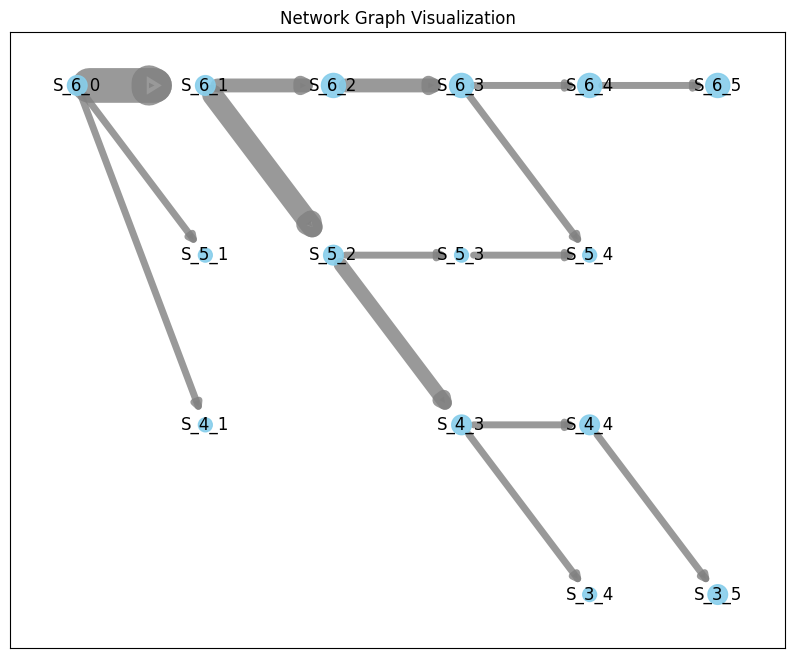

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Node data with count
nodes = {
    'S_6_0': {'count': 2}, 
    'S_6_1': {'count': 2}, 
    'S_5_2': {'count': 2}, 
    'S_4_3': {'count': 2}, 
    'S_4_4': {'count': 2}, 
    'S_3_5': {'count': 2}, 
    'S_3_4': {'count': 1, 'exemplar': True}, 
    'S_5_3': {'count': 1, 'exemplar': True}, 
    'S_5_4': {'count': 1, 'exemplar': True}, 
    'S_6_2': {'count': 3}, 
    'S_6_3': {'count': 3}, 
    'S_6_4': {'count': 3}, 
    'S_6_5': {'count': 3}, 
    'S_5_1': {'count': 1, 'exemplar': True}, 
    'S_4_1': {'count': 1, 'exemplar': True}
}

# Edge data with weights
edges = [
    ('S_6_0', 'S_6_1', 5), 
    ('S_6_0', 'S_5_1', 1), 
    ('S_6_0', 'S_4_1', 1), 
    ('S_6_1', 'S_5_2', 3), 
    ('S_6_1', 'S_6_2', 2), 
    ('S_5_2', 'S_4_3', 2), 
    ('S_5_2', 'S_5_3', 1), 
    ('S_4_3', 'S_4_4', 1), 
    ('S_4_3', 'S_3_4', 1), 
    ('S_4_4', 'S_3_5', 1), 
    ('S_5_3', 'S_5_4', 1), 
    ('S_6_2', 'S_6_3', 2), 
    ('S_6_3', 'S_6_4', 1), 
    ('S_6_3', 'S_5_4', 1), 
    ('S_6_4', 'S_6_5', 1)
]

# Add nodes to the graph
for node, data in nodes.items():
    G.add_node(node, **data)

# Add edges to the graph
for u, v, weight in edges:
    G.add_edge(u, v, weight=weight)

# Get positions of nodes
pos = {}
for node in G.nodes():
    # Identify the last two components for x and y values
    components = node.split('_')
    if len(components) == 3:
       y = int(components[1])
       x = int(components[2])
       pos[node] = (x, y)

# Size of nodes based on 'count'
sizes = [100 * G.nodes[node]['count'] for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(10, 8))

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="skyblue", alpha=0.9)
nx.draw_networkx_labels(G, pos)

# Draw edges with thickness based on 'weight'
edges = G.edges(data=True)
edge_weights = [5 * edge[2]['weight'] for edge in edges]
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color='gray', alpha=0.8)

# Show the plot
plt.title('Network Graph Visualization')
plt.show()


In [18]:
schema = sententree_vega.vega_sententree(G, w=800, h=300)
vega.save_schema(schema, "schema.vg.json")
with open("../figures/bin_occurance.png", "wb") as f:
    png = vl_convert.vega_to_png(schema, scale=4)
    f.write(png)

vega.display(schema, format="interactive")

[('S_5_I_5_4', {'count': 1, 'exemplar': True}), ('S_6_I_4_1', {'count': 1, 'exemplar': True}), ('S_5_I_5_3', {'count': 2}), ('S_3_I_5_5', {'count': 1, 'exemplar': True}), ('S_4_I_5_4', {'count': 2}), ('S_3_I_6_5', {'count': 2}), ('S_5_I_5_2', {'count': 2}), ('S_4_I_5_5', {'count': 1, 'exemplar': True}), ('S_6_I_3_0', {'count': 2}), ('S_3_I_6_3', {'count': 1, 'exemplar': True}), ('S_5_I_4_1', {'count': 2})]
[('S_5_I_5_4', 'S_4_I_5_5', {'weight': 1}), ('S_5_I_5_3', 'S_4_I_5_4', {'weight': 2}), ('S_5_I_5_3', 'S_5_I_5_4', {'weight': 2}), ('S_4_I_5_4', 'S_3_I_6_5', {'weight': 1}), ('S_4_I_5_4', 'S_4_I_5_5', {'weight': 1}), ('S_4_I_5_4', 'S_3_I_5_5', {'weight': 1}), ('S_5_I_5_2', 'S_5_I_5_3', {'weight': 1}), ('S_5_I_5_2', 'S_3_I_6_3', {'weight': 1}), ('S_6_I_3_0', 'S_5_I_4_1', {'weight': 1}), ('S_6_I_3_0', 'S_6_I_4_1', {'weight': 2}), ('S_5_I_4_1', 'S_5_I_5_2', {'weight': 2})]
{'S_5_I_5_4': (3.901016380854531, 5.075190994217333), 'S_6_I_4_1': (1.0472281854549519, 3.9323024531200046), 'S_5_I_

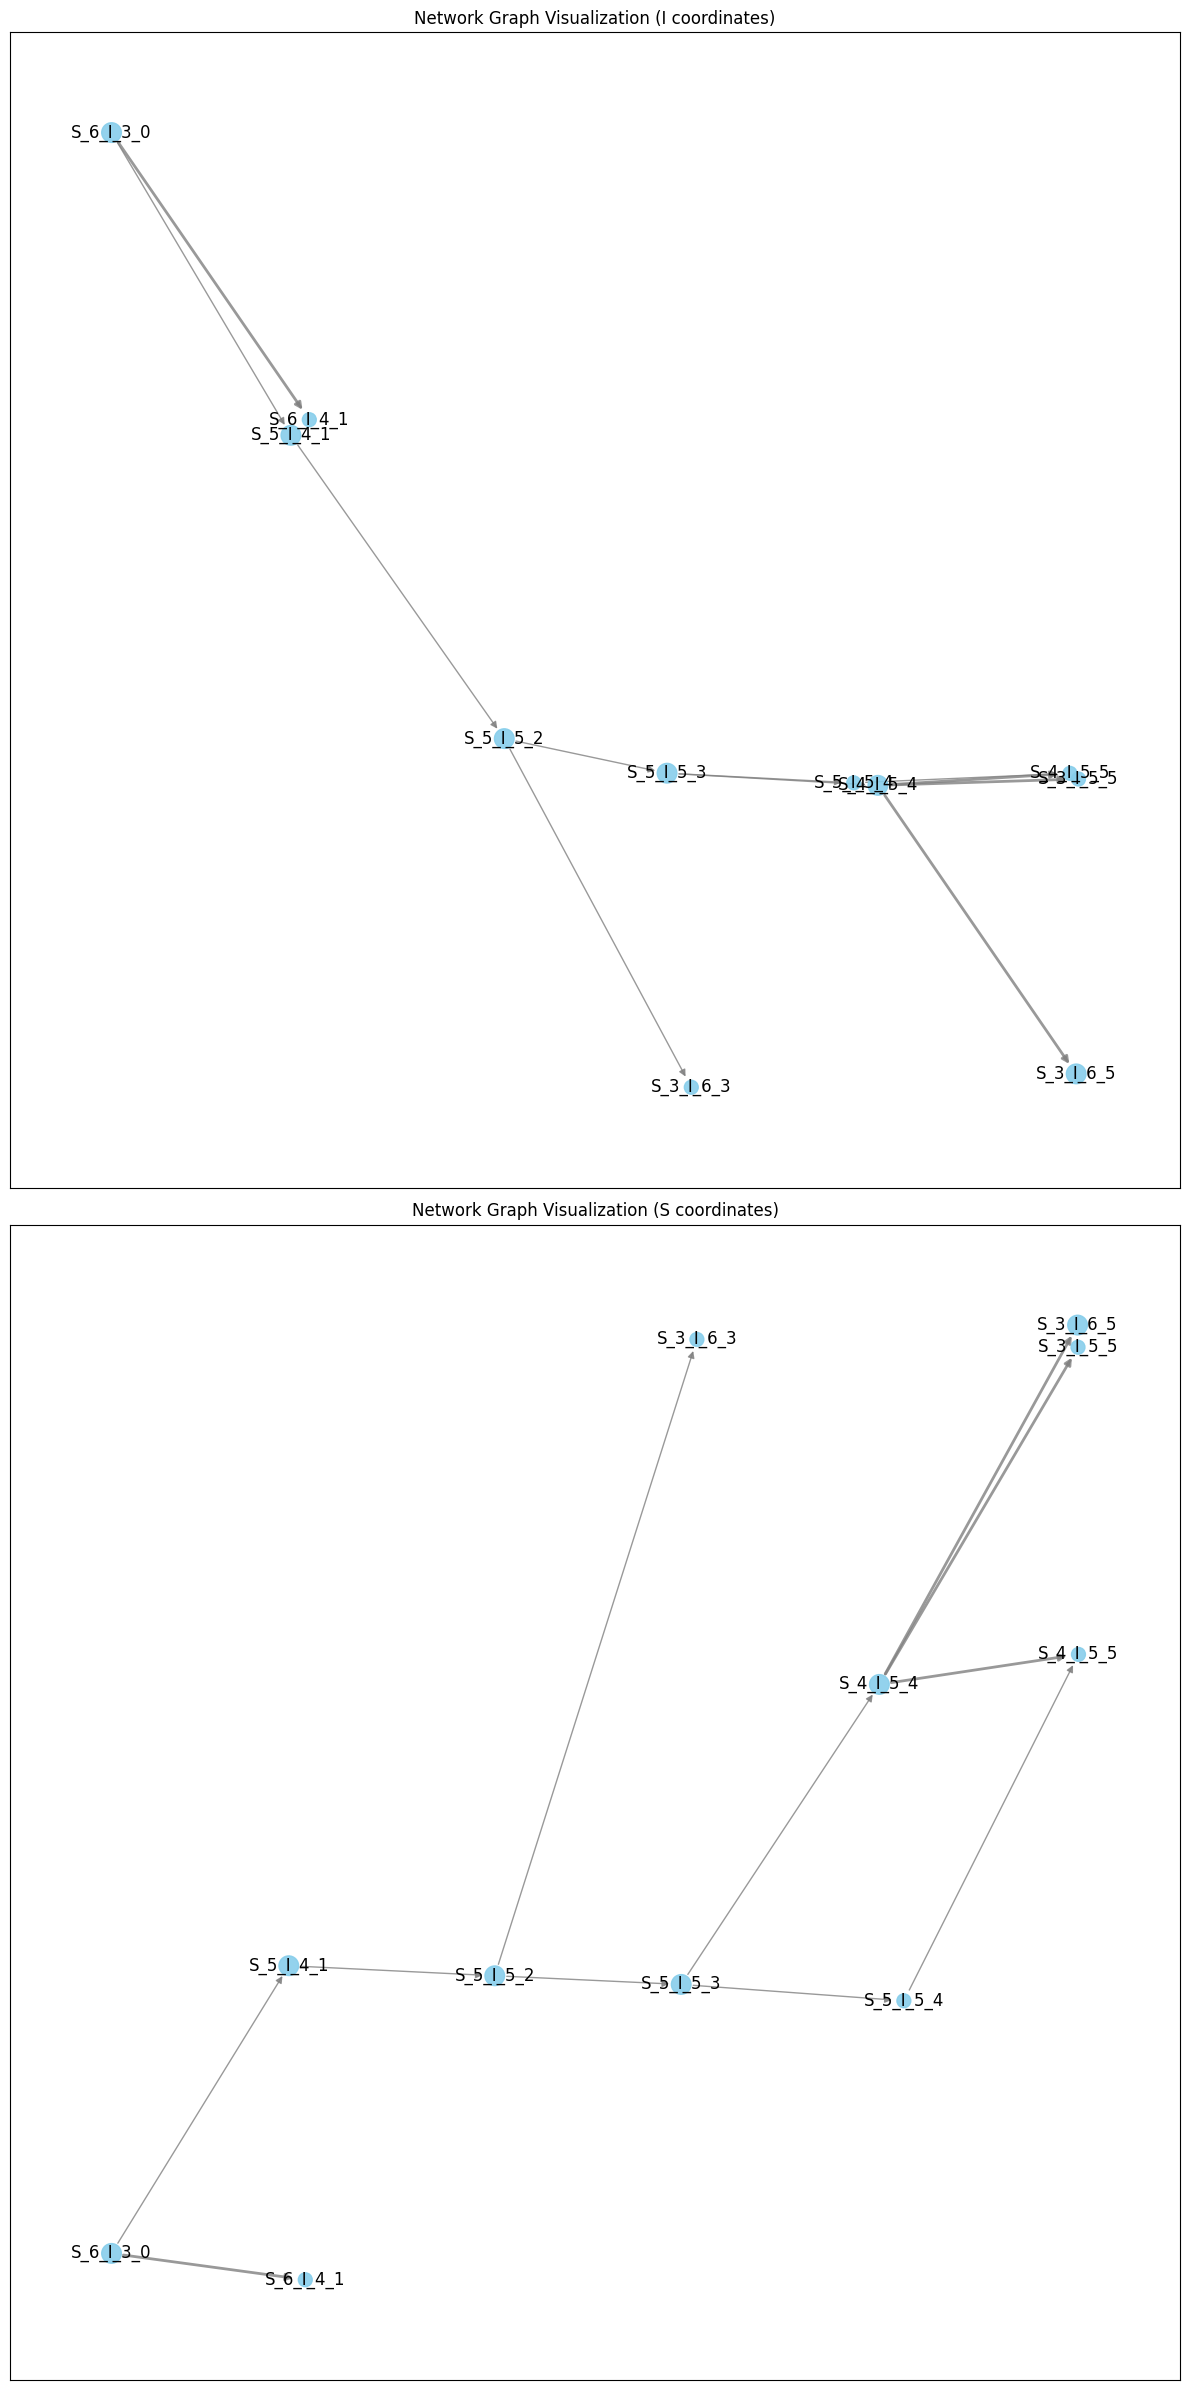

In [36]:
import matplotlib.pyplot as plt
import networkx as nx
import random

# Create a directed graph
G = nx.DiGraph()

# Node data with count
nodes = {
    'S_5_I_5_4': {'count': 1, 'exemplar': True}, 
    'S_6_I_4_1': {'count': 1, 'exemplar': True}, 
    'S_5_I_5_3': {'count': 2}, 
    'S_3_I_5_5': {'count': 1, 'exemplar': True}, 
    'S_4_I_5_4': {'count': 2}, 
    'S_3_I_6_5': {'count': 2}, 
    'S_5_I_5_2': {'count': 2}, 
    'S_4_I_5_5': {'count': 1, 'exemplar': True}, 
    'S_6_I_3_0': {'count': 2}, 
    'S_3_I_6_3': {'count': 1, 'exemplar': True}, 
    'S_5_I_4_1': {'count': 2}
}

# Edge data with weights
edges = [
    ('S_5_I_5_4', 'S_4_I_5_5', 1), 
    ('S_5_I_5_3', 'S_4_I_5_4', 2), 
    ('S_5_I_5_3', 'S_5_I_5_4', 2), 
    ('S_4_I_5_4', 'S_3_I_6_5', 1), 
    ('S_4_I_5_4', 'S_4_I_5_5', 1), 
    ('S_4_I_5_4', 'S_3_I_5_5', 1), 
    ('S_5_I_5_2', 'S_5_I_5_3', 1), 
    ('S_5_I_5_2', 'S_3_I_6_3', 1), 
    ('S_6_I_3_0', 'S_5_I_4_1', 1), 
    ('S_6_I_3_0', 'S_6_I_4_1', 2), 
    ('S_5_I_4_1', 'S_5_I_5_2', 2)
]

# Add nodes to the graph
for node, data in nodes.items():
    G.add_node(node, **data)

# Add edges to the graph
for u, v, weight in edges:
    G.add_edge(u, v, weight=weight)

# Helper function to extract positions with jitter ensuring unique positions
def get_positions_with_jitter(graph, coord, jitter_amount=0.1):
    pos = {}
    unique_positions = set()
    mapping = {}
    for node in graph.nodes():
        components = node.split('_')
        coord_index = components.index(coord)
        new_node_name = '_'.join(components[:len(components)-1])
        
        y_base = int(components[coord_index + 1])
        x_base = int(components[-1])

        # Ensure unique positions by adding jitter until unique
        while True:
            x_value = x_base + random.uniform(-jitter_amount, jitter_amount)
            y_value = y_base + random.uniform(-jitter_amount, jitter_amount)
            if (x_value, y_value) not in unique_positions:
                unique_positions.add((x_value, y_value))
                break

        pos[node] = (x_value, y_value)
        mapping[node] = new_node_name
    return pos, mapping

# Helper function to plot subgraphs
def plot_subgraph(G, coord, ax, title):
    pos, mapping = get_positions_with_jitter(G, coord)
    sizes = [100 * G.nodes[node]['count'] for node in G.nodes()]
    print(G.nodes(data=True))
    print(G.edges(data=True))
    print(pos)
    unique_edges = {(u, v) for u, v in G.edges()}
    edge_weights = [G[u][v]['weight'] for u, v in unique_edges]
    
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=sizes, node_color="skyblue", alpha=0.9)
    nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax,width=edge_weights, edge_color='gray', alpha=0.8)
    
    ax.set_title(title)
    ax.invert_yaxis()

pos, mapping = get_positions_with_jitter(G, 'I')


# Plot graphs for I and S
fig, axs = plt.subplots(2, 1, figsize=(12, 24))

# Plot for I (y-axis: I, x-axis: last number)
plot_subgraph(G, 'I', axs[0], 'Network Graph Visualization (I coordinates)')

# Plot for S (y-axis: S, x-axis: last number)
plot_subgraph(G, 'S', axs[1], 'Network Graph Visualization (S coordinates)')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


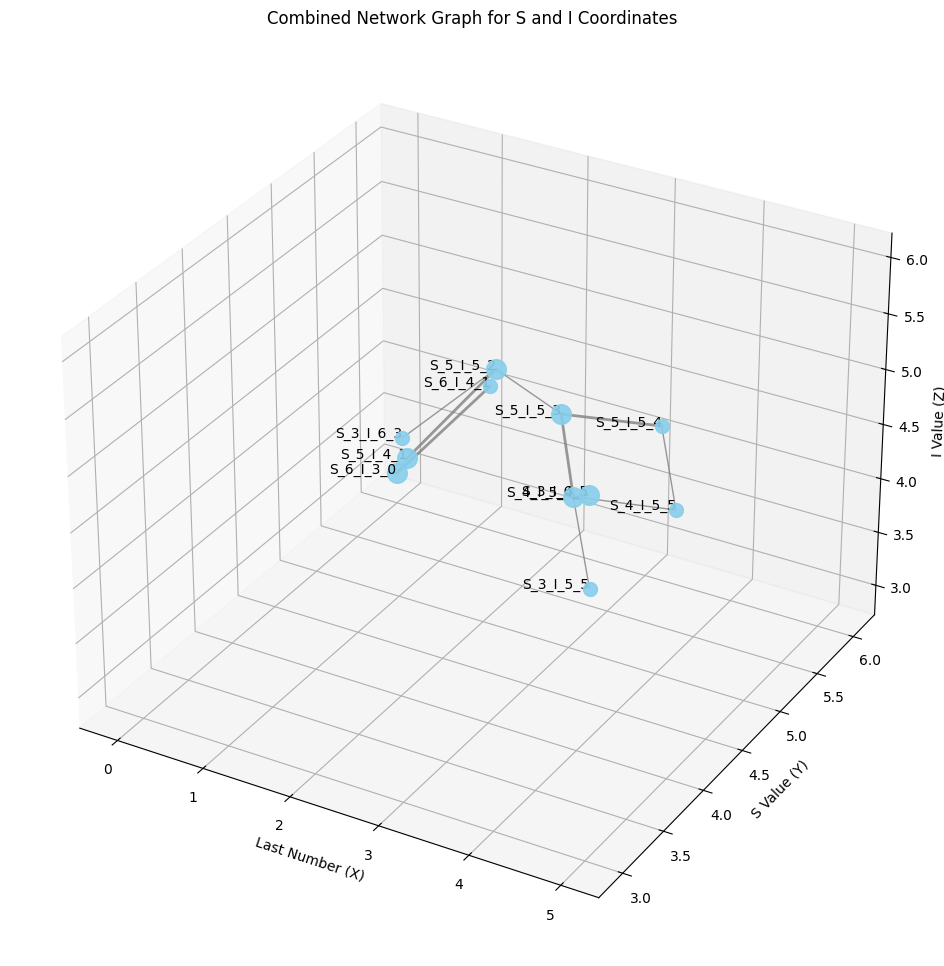

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D

# Create a directed graph
G = nx.DiGraph()

# Node data with count
nodes = {
    'S_5_I_5_4': {'count': 1, 'exemplar': True},
    'S_6_I_4_1': {'count': 1, 'exemplar': True},
    'S_5_I_5_3': {'count': 2},
    'S_3_I_5_5': {'count': 1, 'exemplar': True},
    'S_4_I_5_4': {'count': 2},
    'S_3_I_6_5': {'count': 2},
    'S_5_I_5_2': {'count': 2},
    'S_4_I_5_5': {'count': 1, 'exemplar': True},
    'S_6_I_3_0': {'count': 2},
    'S_3_I_6_3': {'count': 1, 'exemplar': True},
    'S_5_I_4_1': {'count': 2}
}

# Edge data with weights
edges = [
    ('S_5_I_5_4', 'S_4_I_5_5', 1),
    ('S_5_I_5_3', 'S_4_I_5_4', 2),
    ('S_5_I_5_3', 'S_5_I_5_4', 2),
    ('S_4_I_5_4', 'S_3_I_6_5', 1),
    ('S_4_I_5_4', 'S_4_I_5_5', 1),
    ('S_4_I_5_4', 'S_3_I_5_5', 1),
    ('S_5_I_5_2', 'S_5_I_5_3', 1),
    ('S_5_I_5_2', 'S_3_I_6_3', 1),
    ('S_6_I_3_0', 'S_5_I_4_1', 1),
    ('S_6_I_3_0', 'S_6_I_4_1', 2),
    ('S_5_I_4_1', 'S_5_I_5_2', 2)
]

# Add nodes to the graph
for node, data in nodes.items():
    G.add_node(node, **data)

# Add edges to the graph
for u, v, weight in edges:
    G.add_edge(u, v, weight=weight)

# Helper function to extract positions with jitter ensuring unique positions
def get_positions_with_jitter_3d(graph, jitter_amount=0.1):
    pos_3d = {}
    unique_positions = set()
    for node in graph.nodes():
        components = node.split('_')
        s_value = int(components[components.index('S') + 1])
        i_value = int(components[components.index('I') + 1])
        last_value = int(components[-1])

        # Ensure unique positions by adding jitter until unique
        while True:
            x_value = last_value + random.uniform(-jitter_amount, jitter_amount)
            y_value = s_value + random.uniform(-jitter_amount, jitter_amount)
            z_value = i_value + random.uniform(-jitter_amount, jitter_amount)
            if (x_value, y_value, z_value) not in unique_positions:
                unique_positions.add((x_value, y_value, z_value))
                break

        pos_3d[node] = (x_value, y_value, z_value)
    return pos_3d

# Extract positions using jitter
pos_3d = get_positions_with_jitter_3d(G)

# Plot combined 3D graph
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

sizes = [100 * G.nodes[node]['count'] for node in G.nodes()]
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

for node, (x, y, z) in pos_3d.items():
    ax.scatter(x, y, z, s=sizes.pop(0), color='skyblue', alpha=0.9)

for u, v in G.edges():
    x = [pos_3d[u][0], pos_3d[v][0]]
    y = [pos_3d[u][1], pos_3d[v][1]]
    z = [pos_3d[u][2], pos_3d[v][2]]
    ax.plot(x, y, z, color='gray', alpha=0.8, linewidth=edge_weights.pop(0))

for node, (x, y, z) in pos_3d.items():
    ax.text(x, y, z, node, fontsize=10, ha='right')

ax.set_xlabel('Last Number (X)')
ax.set_ylabel('S Value (Y)')
ax.set_zlabel('I Value (Z)')
ax.set_title('Combined Network Graph for S and I Coordinates')

plt.show()
